# 04 MNIST Example with DataLoaders and Convolutions

In this notebook we will look at how data loaders can be used in `pycox`.
This is particularly useful when working with larger data sets than what is possible to fit in memory, and is an important part of any deep learning framework.
As `pycox` is build on [torchtuples](https://github.com/havakv/torchtuples), the same principles applies as for `torchtuples.Model`.

For our example, we will consider the [simulation study proposed by Gensheimer and Narasimhan](https://peerj.com/articles/6257/) based on the MNIST data set of handwritten digits. 
The basic ideas is that each digit represents a survival function, so if we can identify the digit, it is quite straight forward to get good survival estimates.
We will use the `LogisticHazard` methods (which [Gensheimer and Narasimhan](https://peerj.com/articles/6257/) refer to as Nnet-survival), with a convolutional network.

We will however, consider a slightly different survival function than that of [Gensheimer and Narasimhan](https://peerj.com/articles/6257/), and we will consider all the digits from 0 to 9, while [Gensheimer and Narasimhan](https://peerj.com/articles/6257/) only considered the first 5.

In [98]:
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader 

# MNIST is part of torchvision
from torchvision import datasets, transforms


import torchtuples as tt
from pycox.models import LogisticHazard
from pycox.utils import kaplan_meier
from pycox.evaluation import EvalSurv

In [99]:
# for reproducability
np.random.seed(1234)
_ = torch.manual_seed(1234)

# The Dataset

We start by obtaining the MNIST data set with standard preprocessing. The `transform` ensures the data is a `torch.Tensor` and normalize with with a mean and standard deviation.

In [100]:
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.1307,), (0.3081,))]
)
mnist_train = datasets.MNIST('.', train=True, download=True,
                             transform=transform)
mnist_test = datasets.MNIST('.', train=False, transform=transform)

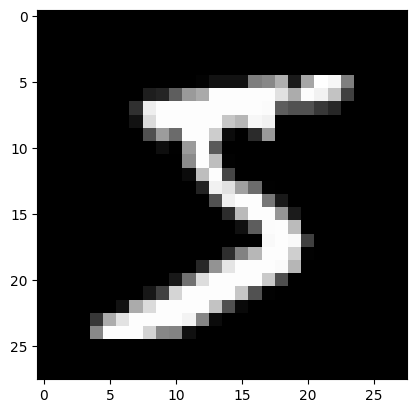

In [101]:
_ = plt.imshow(mnist_train[0][0][0].numpy(), cmap='gray')

## Simulation

Next we need to simulate the responses corresponding to the images.
We draw event times from an exponential distribution with the digit defining the scale parameter

$$
\beta(\text{digit}) = \frac{365 \cdot \exp(-0.6 \cdot \text{digit})}{\log(1.2)},
$$
and we censor all times higher than 700.

In [102]:
def sim_event_times(mnist, max_time=700):
    digits = mnist.targets.numpy()
    betas = 365 * np.exp(-0.6 * digits) / np.log(1.2)
    event_times = np.random.exponential(betas)
    censored = event_times > max_time
    event_times[censored] = max_time
    return tt.tuplefy(event_times, ~censored)

We simulate a training set and test set, based on the respective MNIST data sets.

In [103]:
mnist_train.targets.numpy()

array([5, 0, 4, ..., 5, 6, 8], dtype=int64)

In [104]:
mnist_test.targets.numpy()

array([7, 2, 1, ..., 4, 5, 6], dtype=int64)

In [105]:
sim_train = sim_event_times(mnist_train)
sim_test = sim_event_times(mnist_test)

In [106]:
sim_test

(array([ 10.42829987, 700.        , 700.        , ..., 191.88540975,
         11.6321451 ,  25.84357732]),
 array([ True, False, False, ...,  True,  True,  True]))

In [107]:
sim_train

(array([ 21.19004682, 700.        , 104.56743096, ..., 121.80432849,
          2.50843078,  13.8114342 ]),
 array([ True, False,  True, ...,  True,  True,  True]))

### Visualize
We can visualize the survival curves for the 10 digits by applying the Kaplan-Meier estimator to the collection of event times for each digit

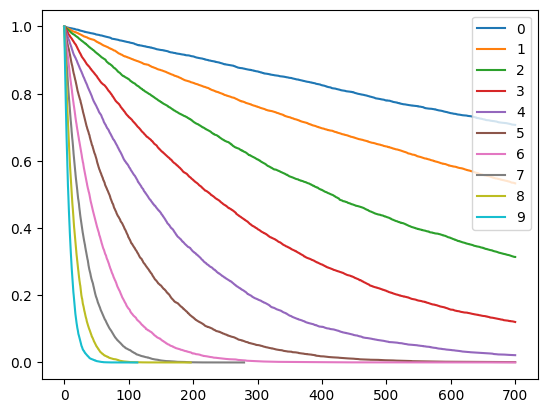

In [108]:
for i in range(10):
    idx = mnist_train.targets.numpy() == i
    kaplan_meier(*sim_train.iloc[idx]).rename(i).plot()
_ = plt.legend()

Our goal will be to estimate these survival functions from the images.

## Label transforms

Our simulated event times are drawn in continuous time, so to apply the `LogisticHazard` method, we need to discretize the observations. This can be done with the `label_transform` attribute, and we here use an equidistant grid with 20 grid points.

In [109]:
labtrans = LogisticHazard.label_transform(20)
target_train = labtrans.fit_transform(*sim_train)
target_test = labtrans.transform(*sim_test)

The disretization grid is 

In [110]:
labtrans.cuts

array([  0.        ,  36.84210526,  73.68421053, 110.52631579,
       147.36842105, 184.21052632, 221.05263158, 257.89473684,
       294.73684211, 331.57894737, 368.42105263, 405.26315789,
       442.10526316, 478.94736842, 515.78947368, 552.63157895,
       589.47368421, 626.31578947, 663.15789474, 700.        ])

and the discrete targets are

In [111]:
target_train

(array([ 1, 19,  3, ...,  4,  1,  1], dtype=int64),
 array([1., 0., 1., ..., 1., 1., 1.], dtype=float32))

# Make DataLoaders

To make a `DataLoader` we first need to create a `Dataset`. The `DataSet` is responsible for the obtaining and transforming the data, while the `DataLoader` is contains a `DataSet` a batch sampler etc.

The standard way to create a `Dataset` in PyTorch is by inheriting the `Dataset` class and defining the `__getitem__` method which reads the data for one individual at a time. 
This also require a `collate_fn` for combining multiple individuals into a batch. 

The following is an example of this approach, but we will shortly present an alternative approach that is more in line with `torchtuples`.

In [112]:
class MnistSimDatasetSingle(Dataset):
    """Simulatied data from MNIST. Read a single entry at a time.
    """
    def __init__(self, mnist_dataset, time, event):
        self.mnist_dataset = mnist_dataset
        self.time, self.event = tt.tuplefy(time, event).to_tensor()

    def __len__(self):
        return len(self.mnist_dataset)

    def __getitem__(self, index):
        if type(index) is not int:
            raise ValueError(f"Need `index` to be `int`. Got {type(index)}.")
        img = self.mnist_dataset[index][0]
        return img, (self.time[index], self.event[index])

In [113]:
dataset_train = MnistSimDatasetSingle(mnist_train, *target_train)
dataset_test = MnistSimDatasetSingle(mnist_test, *target_test)

In [114]:
samp = tt.tuplefy(dataset_train[1])
samp.shapes()

(torch.Size([1, 28, 28]), (torch.Size([]), torch.Size([])))

In [115]:
samp[1]

(tensor(19), tensor(0.))

Our dataset gives a nested tuple `(img, (idx_duration, event))`, meaning the default collate in PyTorch does not work. We therefore use `tuplefy` to stack the tensors instead

In [116]:
def collate_fn(batch):
    """Stacks the entries of a nested tuple"""
    return tt.tuplefy(batch).stack()

### DataLoader

We can now use the regular pytorch `DataLoader`.
Note that you can set the argument `num_workers` in the `DataLoader` to use multiple processes for reading data. Dependent on the system (mac/linux/windows) this can cause some memory issues, so we here use the default `num_workers = 0`.

In [117]:
batch_size = 128

In [118]:
dl_train = DataLoader(dataset_train, batch_size, shuffle=True, collate_fn=collate_fn)
dl_test = DataLoader(dataset_test, batch_size, shuffle=False, collate_fn=collate_fn)

If we now investigate a batch, we see that we have the same tuple structure `(img, (idx_durations, events))` but in a batch of size 128.

In [119]:
batch = next(iter(dl_train))
batch.shapes()

(torch.Size([128, 1, 28, 28]), (torch.Size([128]), torch.Size([128])))

In [120]:
batch.dtypes()

(torch.float32, (torch.int64, torch.float32))

## Dataset with batches (alternative)

When working with `torchtuples` it is typically simpler to read a batch at a times. This means that we do not need a `collate_fn`, and all the logic is in the `Dataset`.
This approach is not needed, and if you prefer the regular PyTorch `DataLoader`, you can skip this and continue at the Convolutional Network section.

In [121]:
class MnistSimDatasetBatch(Dataset):
    def __init__(self, mnist_dataset, time, event):
        self.mnist_dataset = mnist_dataset
        self.time, self.event = tt.tuplefy(time, event).to_tensor()

    def __len__(self):
        return len(self.time)

    def __getitem__(self, index):
        if not hasattr(index, '__iter__'):
            index = [index]
        img = [self.mnist_dataset[i][0] for i in index]
        img = torch.stack(img)
        return tt.tuplefy(img, (self.time[index], self.event[index]))

In [122]:
dataset_train = MnistSimDatasetBatch(mnist_train, *target_train)
dataset_test = MnistSimDatasetBatch(mnist_test, *target_test)

In [123]:
samp = dataset_train[[0, 1, 3]]
samp.shapes()

(torch.Size([3, 1, 28, 28]), (torch.Size([3]), torch.Size([3])))

### DataLoaderBatch

As we have a `Dataset` that reads a batch at a time, we cannot use the regular pytorch `DataLoader`.
Instead we have to rely on the `DataLoaderBatch` from `torchtuples`, but note that we don't need the `collate_fn`.

In [124]:
dl_train = tt.data.DataLoaderBatch(dataset_train, batch_size, shuffle=True)
dl_test = tt.data.DataLoaderBatch(dataset_test, batch_size, shuffle=False)

In [125]:
batch = next(iter(dl_train))
batch.shapes()

(torch.Size([128, 1, 28, 28]), (torch.Size([128]), torch.Size([128])))

In [126]:
batch.dtypes()

(torch.float32, (torch.int64, torch.float32))

We see that the end result is the same as for thte `DataLoader` above, so use the methods you find the simplest.

# Convolutional Network

We will use a convolutional network with two convolutional layers, global average pooling, and two dense layers. This networks is very basic, so better performance would be expected with a more carefully designed network.

In [127]:
class Net(nn.Module):
    def __init__(self, out_features):
        super().__init__()
        self.conv1 = nn.Conv2d(1, 16, 5, 1)
        self.max_pool = nn.MaxPool2d(2)
        self.conv2 = nn.Conv2d(16, 16, 5, 1)
        self.glob_avg_pool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc1 = nn.Linear(16, 16)
        self.fc2 = nn.Linear(16, out_features)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = self.max_pool(x)
        x = F.relu(self.conv2(x))
        x = self.glob_avg_pool(x)
        x = torch.flatten(x, 1)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

In [128]:
net = Net(labtrans.out_features)
net

Net(
  (conv1): Conv2d(1, 16, kernel_size=(5, 5), stride=(1, 1))
  (max_pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(16, 16, kernel_size=(5, 5), stride=(1, 1))
  (glob_avg_pool): AdaptiveAvgPool2d(output_size=(1, 1))
  (fc1): Linear(in_features=16, out_features=16, bias=True)
  (fc2): Linear(in_features=16, out_features=20, bias=True)
)

## The Logistic-Hazard Model

We use the `LogisticHazard` with the Adam optimizer with a learning rate of 0.01.

In [129]:
model = LogisticHazard(net, tt.optim.Adam(0.01), duration_index=labtrans.cuts)

To verify that the network works as expected we can use the batch from before

In [130]:
pred = model.predict(batch[0])
pred.shape

torch.Size([128, 20])

### Training

We fit the network with `fit_dataloader` and use the `dl_test` to monitor the test performance. It should go without saying that, in practice, we need a validation set separate from the test set when we use early stopping, but this is just an illustrative example.

In [131]:
callbacks = [tt.cb.EarlyStopping(patience=5)]
epochs = 50
verbose = True
log = model.fit_dataloader(dl_train, epochs, callbacks, verbose, val_dataloader=dl_test)

0:	[54s / 54s],		train_loss: 2.0557,	val_loss: 1.8714
1:	[52s / 1m:46s],		train_loss: 1.8474,	val_loss: 1.7899
2:	[47s / 2m:34s],		train_loss: 1.7784,	val_loss: 1.7579
3:	[47s / 3m:21s],		train_loss: 1.7584,	val_loss: 1.7403
4:	[47s / 4m:8s],		train_loss: 1.7455,	val_loss: 1.7303
5:	[50s / 4m:59s],		train_loss: 1.7430,	val_loss: 1.7453
6:	[50s / 5m:49s],		train_loss: 1.7309,	val_loss: 1.7122
7:	[46s / 6m:36s],		train_loss: 1.7230,	val_loss: 1.7067
8:	[41s / 7m:17s],		train_loss: 1.7186,	val_loss: 1.7117
9:	[46s / 8m:3s],		train_loss: 1.7122,	val_loss: 1.7073
10:	[46s / 8m:50s],		train_loss: 1.7110,	val_loss: 1.6971
11:	[50s / 9m:40s],		train_loss: 1.7095,	val_loss: 1.6982
12:	[51s / 10m:32s],		train_loss: 1.7088,	val_loss: 1.6977
13:	[48s / 11m:20s],		train_loss: 1.7040,	val_loss: 1.6958
14:	[50s / 12m:11s],		train_loss: 1.7014,	val_loss: 1.6931
15:	[50s / 13m:1s],		train_loss: 1.7000,	val_loss: 1.6938
16:	[47s / 13m:49s],		train_loss: 1.6983,	val_loss: 1.6904
17:	[48s / 14m:37s],		tra

c:\Users\kavin\miniconda3\envs\pycox\lib\site-packages\torchtuples\base.py:669: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  self.net.load_state_dict(torch.load(path, **kwa

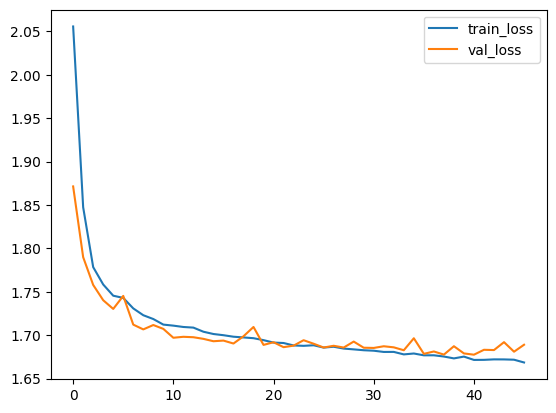

In [132]:
_ = log.plot()

# Prediction

To predict, we need a data loader that only gives the images and not the targets. We therefore need to create a new `Dataset` for this purpose.

In [133]:
class MnistSimInput(Dataset):
    def __init__(self, mnist_dataset):
        self.mnist_dataset = mnist_dataset

    def __len__(self):
        return len(self.mnist_dataset)

    def __getitem__(self, index):
        img = self.mnist_dataset[index][0]
        return img

In [134]:
dataset_test_x = MnistSimInput(mnist_test)
dl_test_x = DataLoader(dataset_test_x, batch_size, shuffle=False)

In [135]:
next(iter(dl_test_x)).shape

torch.Size([128, 1, 28, 28])

### (alternative)
Alternatively, if you have used the batch method, we can use the method `dataloader_input_only` to create this `Dataloader` from `dl_test`.

In [136]:
dl_test_x = tt.data.dataloader_input_only(dl_test)

In [137]:
next(iter(dl_test_x)).shape

torch.Size([128, 1, 28, 28])

### Survial predictions

We can obtain survival prediction in the regular manner, and one can include the `interpolation` if wanted.

In [138]:
surv = model.predict_surv_df(dl_test_x)

# Results

We compute the average survival predictions for each digit in the test set

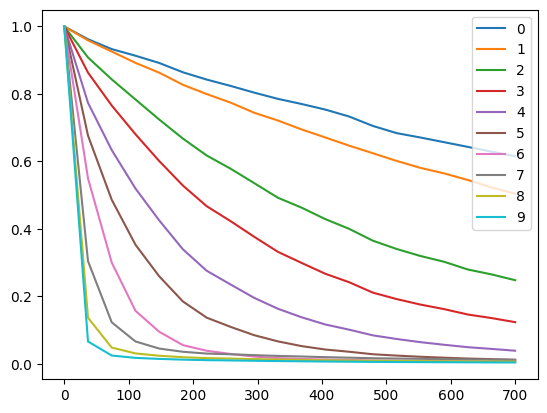

In [139]:
for i in range(10):
    idx = mnist_test.targets.numpy() == i
    surv.loc[:, idx].mean(axis=1).rename(i).plot()
_ = plt.legend()

and find that they are quite similar to the Kaplan-Meier estimates!

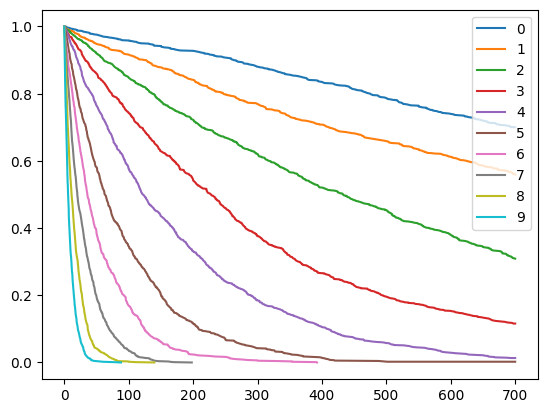

In [140]:
for i in range(10):
    idx = mnist_test.targets.numpy() == i
    kaplan_meier(*sim_test.iloc[idx]).rename(i).plot()
_ = plt.legend()

### Concordance and Brier score

In [141]:
surv = model.interpolate(10).predict_surv_df(dl_test_x)

In [142]:
ev = EvalSurv(surv, *sim_test, 'km')

In [143]:
ev.concordance_td()

0.7509912362175493

In [144]:
time_grid = np.linspace(0, sim_test[0].max())
ev.integrated_brier_score(time_grid)

0.10470343921668566

# Next

You can now look at other examples of survival methods in the [examples folder](https://nbviewer.jupyter.org/github/havakv/pycox/tree/master/examples).
Or, alternatively take a look at

- the more advanced training procedures in the notebook [02_introduction.ipynb](https://nbviewer.jupyter.org/github/havakv/pycox/blob/master/examples/02_introduction.ipynb).
- other network architectures that combine autoencoders and survival networks in the notebook [03_network_architectures.ipynb](https://nbviewer.jupyter.org/github/havakv/pycox/blob/master/examples/03_network_architectures.ipynb).